In [1]:
import pandas as pd
import torch
from transformers import AutoTokenizer, DataCollatorWithPadding
import torch.nn as nn
from transformers import AutoModel
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.utils.class_weight import compute_class_weight
import warnings
import random
import ast
import torch.nn.functional as F
from sklearn.metrics import classification_report, f1_score, confusion_matrix, ConfusionMatrixDisplay
from torch.optim.lr_scheduler import MultiStepLR
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt



warnings.filterwarnings('ignore')

/home/pepe/miniconda3/envs/nlp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
TOKEN_DIM = 128
PROB = 0.3
DROPOUT = 0.2
EMBED_DIM = 768
BATCH_SIZE = 16
LR = 1e-5
WD = 1e-2
EPOCHS = 10
ACTIVATION = nn.GELU()
DATA_AUG = False

language = "ESP"

if language == "ENG":
    MODEL_NAME = "cardiffnlp/twitter-roberta-base-sentiment-latest"
    text_col = "translation" 
    emb_col = "embeddings_ingles" 
    par_col = "paraphrase" 
    par_emb_col_1 = "embedding_paraphrase1" 
    par_emb_col_2 = "embedding_paraphrase2" 
    TOKEN_DIM = TOKEN_DIM


else: 
    MODEL_NAME = "pysentimiento/robertuito-sentiment-analysis"
    text_col = "post content"
    emb_col = "embeddings"
    par_col = "paraphrase_esp"
    par_emb_col_1 = "embedding_paraphrase_esp1"
    par_emb_col_2 = "embedding_paraphrase_esp2"
    TOKEN_DIM = 128


In [3]:
def load_dataset(path_to_dataset):
    return pd.read_csv(path_to_dataset, index_col = 0)

def extract_similar_descriptions(e, embeddings, k):
    similarities = cosine_similarity([e], embeddings)[0]
    top_indices = np.argsort(similarities)[-k:][::-1]
    return top_indices
    
def compute_embeddings_distance(embedding_str, k, df):
    #df = load_dataset(path_to_dataset)

    # QUitamos del dataset la misma fila con la que estamos trabajando
    df = df[df[emb_col]!= embedding_str]

    def parse_embedding(embedding_str):
        embedding_str = embedding_str.strip("[]")
        return np.array(embedding_str.split(), dtype=np.float32)
    
    embedding = parse_embedding(embedding_str)
    df[emb_col] = df[emb_col].apply(lambda x: parse_embedding(x))

    df_pos = df[df["label"]==2]
    df_neu = df[df["label"]==1]
    df_neg = df[df["label"]==0]

    pos_description_embeddings = np.vstack(df_pos[emb_col].values)
    pos_nearest_descriptions = extract_similar_descriptions(embedding, pos_description_embeddings, k)
    pos_result = df_pos.iloc[pos_nearest_descriptions][text_col]

    neu_description_embeddings = np.vstack(df_neu[emb_col].values)
    neu_nearest_descriptions = extract_similar_descriptions(embedding, neu_description_embeddings, k)
    neu_result = df_neu.iloc[neu_nearest_descriptions][text_col]

    neg_description_embeddings = np.vstack(df_neg[emb_col].values)
    neg_nearest_descriptions = extract_similar_descriptions(embedding, neg_description_embeddings, k)
    neg_result = df_neg.iloc[neg_nearest_descriptions][text_col]
    

    return pos_result.to_list(), neu_result.to_list(), neg_result.to_list()

mapping = {"NEG":0, "NEU":1, "POS":2}

def label2int(label):
    return mapping[label]

In [4]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    print("Device count:", torch.cuda.device_count())
    print("Current device:", torch.cuda.current_device())
    for i in range(torch.cuda.device_count()):
        print(torch.cuda.get_device_name(i))

Device count: 1
Current device: 0
NVIDIA GeForce RTX 4070 Laptop GPU


In [5]:
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

In [6]:
data = load_dataset("../data/data.csv")

In [7]:
# train_df = load_dataset("../data/train_paraphrased.csv")
# test_df = load_dataset("../data/test_paraphrased.csv")
# val_df = load_dataset("../data/val_paraphrased.csv")
# dev_df = load_dataset("../data/dev_paraphrased.csv")
# train_df = pd.concat([train_df, dev_df]).reset_index()

train_df, test_df = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED, stratify=data['label'])
train_df, val_df = train_test_split(train_df, test_size=1/8, random_state=RANDOM_SEED, stratify=train_df['label'])

In [8]:
train_labels = train_df["label"]

In [9]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
print("Class weights:", class_weights)

Class weights: tensor([0.9873, 0.5916, 3.3694], device='cuda:0')


In [10]:
class SentimentDataset(Dataset):
    def __init__(self, texts, paraphrases, labels, tokenizer, k, df, type = None, augmentation = False, local_database = train_df):
        super().__init__() 
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.k = k
        self.df = df
        self.local_database = local_database
        self.paraphrases = paraphrases
        self.type = type
        self.augmentation = augmentation

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        # DATA AUG
        if self.type == "train" and self.augmentation:
            paraphrase = self.paraphrases[idx]
            samples = ast.literal_eval(paraphrase)
            samples=list(samples)
            samples.append(text)
            text = random.choice(samples)
            index = samples.index(text)


            if index == 0:
                embedding_str = self.df.loc[self.df[par_col] == paraphrase, par_emb_col_1].values[0]
            elif index == 1:
                embedding_str = self.df.loc[self.df[par_col] == paraphrase, par_emb_col_2].values[0]
            else: 
                embedding_str = self.df.loc[self.df[text_col] == text, emb_col].values[0]

            words = text.split()
            if random.random() < PROB:
            
                if len(words) > 1:
                    num_to_remove = max(1, int(0.1 * len(words)))  # Quitar ~10% de las palabras
                    indices_to_remove = random.sample(range(len(words)), num_to_remove)
                    words = [w for i, w in enumerate(words) if i not in indices_to_remove]
                    text = " ".join(words)

                if random.random() < PROB:

                    if len(words) > 1:
                        random.shuffle(words)
                        text = " ".join(words)

        else:
            embedding_str = embedding_str = self.df.loc[self.df[text_col] == text, emb_col].values[0]
        
        # Obtener los textos más similares por clase
        pos_texts, neu_texts, neg_texts = compute_embeddings_distance(embedding_str, self.k, self.local_database)
        # Tokenizar el texto principal
        encoding = self.tokenizer(text, padding="max_length", truncation=True, max_length=TOKEN_DIM, return_tensors="pt")

        # Tokenizar los textos más similares
        pos_tokens = self.tokenizer(pos_texts, padding="max_length", truncation=True, max_length=TOKEN_DIM, return_tensors="pt")
        neu_tokens = self.tokenizer(neu_texts, padding="max_length", truncation=True, max_length=TOKEN_DIM, return_tensors="pt")
        neg_tokens = self.tokenizer(neg_texts, padding="max_length", truncation=True, max_length=TOKEN_DIM, return_tensors="pt")
        

        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": torch.tensor(label, dtype=torch.long),
            "pos_tokens": pos_tokens["input_ids"],
            "neu_tokens": neu_tokens["input_ids"],
            "neg_tokens": neg_tokens["input_ids"],
            "pos_attention": pos_tokens["attention_mask"],
            "neu_attention": neu_tokens["attention_mask"],
            "neg_attention": neg_tokens["attention_mask"],
        }

In [11]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

train_dataset = SentimentDataset(
    texts=train_df[text_col].tolist(),
    labels=train_df["label"].tolist(),
    paraphrases=train_df[par_col].tolist(),
    tokenizer=tokenizer,
    k=1,  # Número de mensajes similares a recuperar
    df = train_df,
    type = "train",
    augmentation=DATA_AUG
)

val_dataset = SentimentDataset(
    texts=val_df[text_col].tolist(),
    labels=val_df["label"].tolist(),
    paraphrases = [],
    tokenizer=tokenizer,
    k=1,  # Número de mensajes similares a recuperar
    df = val_df
)

test_dataset = SentimentDataset(
    texts=test_df[text_col].tolist(),
    labels=test_df["label"].tolist(),
    paraphrases = [],
    tokenizer=tokenizer,
    k=1,  # Número de mensajes similares a recuperar
    df = test_df
)

In [12]:
for i in range(1):
    sample = train_dataset[i]
    print(f"Sample {i + 1}:")
    print(f"Text: {train_dataset.texts[i]}")
    print(f"Label: {sample['labels'].item()}")
    print(f"Input IDs: {sample['input_ids']}")
    print(f"Attention Mask: {sample['attention_mask']}")
    print(f"Positives: {sample['pos_tokens']}")
    print(f"Neutral: {sample['neu_tokens']}")
    print(f"Negatives: {sample['neg_tokens']}")
    print(f"Positives: {sample['pos_attention']}")
    print(f"Neutral: {sample['neu_attention']}")
    print(f"Negatives: {sample['neg_attention']}")
    print("\n" + "-"*40 + "\n")

Sample 1:
Text: yo he llegado a pensar que el rechazo, en cuanto a preferencia, contra los `trans` tiene relación con el "uncanny valley", y por lo tanto, es algo que responde al subconciente de las personas, difícil de explicar, pero no por eso menos presente o poderoso. eso hace más complicado responder al asunto, en el caso del sub , me doy cuenta de que en general se utiliza mucho maquillaje en la versión final, y claro, el poder del maquillaje es grande, y con ello salta la pregunta de ¿a qué te refieres con atractiva? una cosa que me faltó acotar, es que en las imágenes de ese sub se nota también que hay personas que tenian cierta apariencia de un género distinto antes de la transformación, no hay que olvidar que las disforias se pueden causar por factores genéticos también. yo dudo que seguiría adelante, sabiendo que es una persona `trans`. y esto es hablando del caso en que es indistinguible del caso biológico, el motivo es simple pero un poco pacato, creo que nunca he tenido u

In [13]:
def scaled_dot_product_attention(Q, K, V, mask=None):
    # Compute the dot products between Q and K, then scale by the square root of the key dimension
    d_k = Q.size(-1)
    scores = torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(torch.tensor(d_k, dtype=torch.float32))

    # Apply mask if provided (useful for masked self-attention in transformers)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, float('-inf'))

    # Softmax to normalize scores, producing attention weights
    attention_weights = F.softmax(scores, dim=-1)
    
    # Compute the final output as weighted values
    output = torch.matmul(attention_weights, V)
    return output, attention_weights


class SelfAttention(nn.Module):
    def __init__(self, embed_size):
        super().__init__()
        self.embed_size = embed_size
        # Define linear transformations for Q, K, V
        self.query = nn.Linear(embed_size, embed_size)
        self.key = nn.Linear(embed_size, embed_size)
        self.value = nn.Linear(embed_size, embed_size)

    def forward(self, q, k, v, mask=None):
        # Generate Q, K, V matrices
        Q = self.query(q)
        K = self.key(k)
        V = self.value(v)
        
        # Calculate attention using our scaled dot-product function
        out, _ = scaled_dot_product_attention(Q, K, V)
        return out

In [14]:
class SentimentClassifierWithMultiAttention(nn.Module):
    def __init__(self, base_model_name, num_labels=3, num_heads=3):
        super().__init__()
        
        self.bert = AutoModel.from_pretrained(base_model_name)

        self.attention = nn.MultiheadAttention(embed_dim = EMBED_DIM, num_heads = num_heads)


        """self.linear_intermediate = nn.Linear(EMBED_DIM * 2, EMBED_DIM)
        self.activation = ACTIVATION
        self.dropout = nn.Dropout(DROPOUT)"""
        

        self.feedforward = nn.Sequential(
            nn.Linear(EMBED_DIM * 2, EMBED_DIM),
            ACTIVATION,
            nn.Dropout(DROPOUT),
            nn.Linear(EMBED_DIM, EMBED_DIM // 2),
            ACTIVATION,
            nn.Dropout(DROPOUT),
            nn.Linear(EMBED_DIM // 2, EMBED_DIM // 4),
            ACTIVATION,
            nn.Dropout(DROPOUT)
        )

        self.classifier = nn.Linear(EMBED_DIM // 4, num_labels)


    def forward(self, input_ids, attention_mask, labels=None, pos_tokens=None, neu_tokens=None, neg_tokens=None, pos_attention=None, neu_attention = None, neg_attention = None):
        
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        cls_embedding = outputs.last_hidden_state[:, 0, :]  # Token CLS
        cls_embedding_expanded = cls_embedding.unsqueeze(1)

        pos_outputs_0 = self.bert(pos_tokens[:,0,:], attention_mask=pos_attention[:,0,:])
        pos_cls_embedding_0 = pos_outputs_0.last_hidden_state[:, 0, :]
        pos_cls_embedding_0 = pos_cls_embedding_0.unsqueeze(1)  

        pos_cls_embedding = pos_cls_embedding_0

        neu_outputs_0 = self.bert(neu_tokens[:,0,:], attention_mask=neu_attention[:,0,:])
        neu_cls_embedding_0 = neu_outputs_0.last_hidden_state[:, 0, :]
        neu_cls_embedding_0 = neu_cls_embedding_0.unsqueeze(1)  

        neu_cls_embedding = neu_cls_embedding_0

        neg_outputs_0 = self.bert(neg_tokens[:,0,:], attention_mask=neg_attention[:,0,:])
        neg_cls_embedding_0 = neg_outputs_0.last_hidden_state[:, 0, :]
        neg_cls_embedding_0 = neg_cls_embedding_0.unsqueeze(1)  

        neg_cls_embedding = neg_cls_embedding_0

        cls_embedding_expanded = cls_embedding_expanded.float()
        pos_cls_embedding = pos_cls_embedding.float()
        neg_cls_embedding = neg_cls_embedding.float()
        neu_cls_embedding = neu_cls_embedding.float()

        
        
        class_embed = torch.cat([pos_cls_embedding, neg_cls_embedding, neu_cls_embedding])
        contextual_emb, _ = self.attention(cls_embedding_expanded, class_embed, class_embed)
        contextual_emb = contextual_emb.squeeze(1)

        

        combined_embedding = torch.cat([
            cls_embedding,
            contextual_emb
        ], dim=-1)
        

        #logits = self.classifier(self.dropout(self.activation(self.linear_intermediate(combined_embedding))))
        logits = self.classifier(self.feedforward(combined_embedding))

        return logits



model = SentimentClassifierWithMultiAttention(MODEL_NAME, num_labels=3)


Some weights of RobertaModel were not initialized from the model checkpoint at pysentimiento/robertuito-sentiment-analysis and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Congelamos todas las capas menos la última capa de clasificación

In [15]:
# for param in list(model.bert.parameters()):
#    param.requires_grad = False

In [16]:
model.to(device)

SentimentClassifierWithMultiAttention(
  (bert): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(30002, 768, padding_idx=1)
      (position_embeddings): Embedding(130, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
       

In [17]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=data_collator)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=data_collator)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=data_collator)

### Fine-Tuning Context Awareness Model

In [18]:
from torch.optim import AdamW

In [19]:
models_path = "../checkpoints/"

optimizer = AdamW(model.parameters(), lr=LR, weight_decay=WD) #, weight_decay=WD

num_epochs = EPOCHS
num_training_steps = num_epochs * len(train_dataloader)
scheduler = MultiStepLR(optimizer, milestones=[8], gamma=0.1)


print(num_training_steps)

3160


In [20]:
from tqdm.auto import tqdm

train_losses = []
val_losses = []
lfunct = nn.CrossEntropyLoss(weight=class_weights)

progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0 
    num_train_batches = 0

    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        
        outputs = model(**batch)  # Logits
        y_true = batch["labels"]
        
        loss = lfunct(outputs, y_true)

        loss.backward()

        optimizer.step()
        #scheduler.step()

        optimizer.zero_grad()
        
        # Accumulate loss
        epoch_train_loss += loss.item()
        num_train_batches += 1

        progress_bar.update(1)

    # Compute average training loss for the epoch
    avg_train_loss = epoch_train_loss / num_train_batches
    train_losses.append(avg_train_loss)
    
    # Run validation
    model.eval()
    epoch_val_loss = 0
    num_val_batches = 0

    y_preds_val = []
    y_trues_val = []

    with torch.no_grad():
        for batch in val_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            y_true = batch["labels"]

            loss = lfunct(outputs, y_true)
            epoch_val_loss += loss.item()
            num_val_batches += 1

            y_preds_val.extend(torch.argmax(outputs, dim=-1).cpu().tolist())
            y_trues_val.extend(batch["labels"].cpu().tolist())

    y_preds_val = np.array(y_preds_val)
    y_trues_val = np.array(y_trues_val)
    f1_val = f1_score(y_trues_val, y_preds_val, average='macro')

    avg_val_loss = epoch_val_loss / num_val_batches
    val_losses.append(avg_val_loss)
    print(f"Epoch {epoch + 1}/{num_epochs:<10} Train Loss: {avg_train_loss:<10.4f} Val Loss: {avg_val_loss:<10.4f} Macro F1: {f1_val:.4f}")

    torch.save(model.state_dict(), f"../checkpoints/{epoch + 1}_context.pth")
    # torch.save(model, f"../checkpoints/{epoch + 1}_full_context_model.pth")

 10%|█         | 316/3160 [34:06<4:24:32,  5.58s/it]

Epoch 1/10         Train Loss: 1.0532     Val Loss: 1.0385     Macro F1: 0.4398


 20%|██        | 632/3160 [1:14:18<3:49:21,  5.44s/it]

Epoch 2/10         Train Loss: 0.9153     Val Loss: 1.0221     Macro F1: 0.4771


 30%|███       | 948/3160 [1:55:56<4:05:04,  6.65s/it] 

Epoch 3/10         Train Loss: 0.7445     Val Loss: 1.1781     Macro F1: 0.5067


 40%|████      | 1264/3160 [2:38:09<2:40:55,  5.09s/it] 

Epoch 4/10         Train Loss: 0.5941     Val Loss: 1.2040     Macro F1: 0.4837


 50%|█████     | 1580/3160 [3:17:19<2:17:24,  5.22s/it] 

Epoch 5/10         Train Loss: 0.4473     Val Loss: 1.4512     Macro F1: 0.4901


 60%|██████    | 1896/3160 [3:57:04<1:37:44,  4.64s/it] 

Epoch 6/10         Train Loss: 0.3271     Val Loss: 1.6678     Macro F1: 0.4852


 70%|███████   | 2212/3160 [4:35:10<1:21:12,  5.14s/it] 

Epoch 7/10         Train Loss: 0.2127     Val Loss: 1.9862     Macro F1: 0.4614


 80%|████████  | 2528/3160 [5:12:29<48:59,  4.65s/it]   

Epoch 8/10         Train Loss: 0.1627     Val Loss: 2.2409     Macro F1: 0.4782


 90%|█████████ | 2844/3160 [5:49:52<28:43,  5.45s/it]   

Epoch 9/10         Train Loss: 0.1191     Val Loss: 2.4985     Macro F1: 0.4788


100%|██████████| 3160/3160 [6:26:38<00:00,  4.74s/it]  

Epoch 10/10         Train Loss: 0.0775     Val Loss: 2.7453     Macro F1: 0.4675


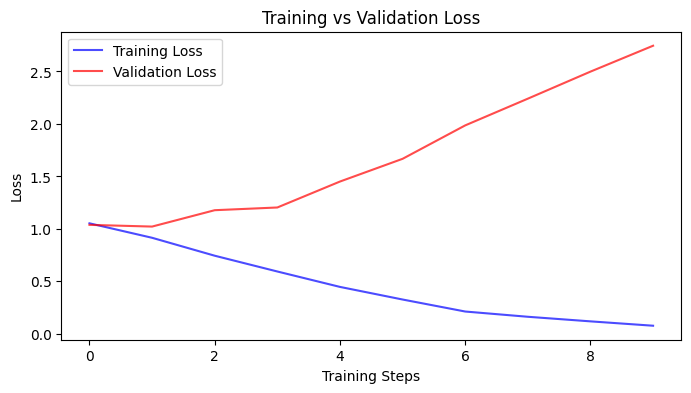

In [21]:
import matplotlib.pyplot as plt
# Plot Training vs Validation Loss
plt.figure(figsize=(8, 4))
plt.plot(train_losses, label="Training Loss", color="blue", alpha=0.7)
plt.plot(val_losses, label="Validation Loss", color="red", alpha=0.7)
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()

### Validation

In [22]:

model.eval()

y_pred_val = []
y_true_val = []
with torch.no_grad(): 
    for batch in val_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        y_pred_val.extend(torch.argmax(outputs, dim=-1).tolist())
        y_true_val.extend(batch["labels"].tolist())

y_pred_val = np.array(y_pred_val)
y_true_val = np.array(y_true_val)
print(y_pred_val.shape, y_true_val.shape)
print(classification_report(y_true_val, y_pred_val, target_names=mapping.keys()))

(721,) (721,)
              precision    recall  f1-score   support

         NEG       0.50      0.52      0.51       244
         NEU       0.65      0.67      0.66       406
         POS       0.28      0.20      0.23        71

    accuracy                           0.57       721
   macro avg       0.48      0.46      0.47       721
weighted avg       0.56      0.57      0.57       721



### Test

In [23]:

model.eval()

y_pred_test = []
y_true_test = []
with torch.no_grad(): 
    for batch in test_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        y_pred_test.extend(torch.argmax(outputs, dim=-1).tolist())
        y_true_test.extend(batch["labels"].tolist())

y_pred_test = np.array(y_pred_test)
y_true_test = np.array(y_true_test)
print(y_pred_test.shape, y_true_test.shape)
print(classification_report(y_true_test, y_pred_test, target_names=mapping.keys()))

(1442,) (1442,)
              precision    recall  f1-score   support

         NEG       0.52      0.53      0.53       487
         NEU       0.66      0.68      0.67       812
         POS       0.36      0.27      0.31       143

    accuracy                           0.59      1442
   macro avg       0.52      0.50      0.50      1442
weighted avg       0.58      0.59      0.59      1442



In [24]:
state_dict = torch.load("../checkpoints/4_context.pth", map_location=torch.device(device)) 
model = SentimentClassifierWithMultiAttention(MODEL_NAME, num_labels=3)
model.load_state_dict(state_dict)
model.to(device)

Some weights of RobertaModel were not initialized from the model checkpoint at pysentimiento/robertuito-sentiment-analysis and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


SentimentClassifierWithMultiAttention(
  (bert): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(30002, 768, padding_idx=1)
      (position_embeddings): Embedding(130, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
       

In [25]:
def predict_sample(model, tokenizer, sample_text, label, embedding_str):
    """
    Predict the sentiment of a sample text
    """

    pos_texts, neu_texts, neg_texts = compute_embeddings_distance(embedding_str, 1, train_df)
    encoding = tokenizer(sample_text, padding="max_length", truncation=True, max_length=TOKEN_DIM, return_tensors="pt")

    # Tokenizar los textos más similares
    pos_tokens = tokenizer(pos_texts, padding="max_length", truncation=True, max_length=TOKEN_DIM, return_tensors="pt")
    neu_tokens = tokenizer(neu_texts, padding="max_length", truncation=True, max_length=TOKEN_DIM, return_tensors="pt")
    neg_tokens = tokenizer(neg_texts, padding="max_length", truncation=True, max_length=TOKEN_DIM, return_tensors="pt")
    

    inputs = {
        "input_ids": encoding["input_ids"],
        "attention_mask": encoding["attention_mask"],
        "labels": torch.tensor(label, dtype=torch.long),
        "pos_tokens": pos_tokens["input_ids"].unsqueeze(1),
        "neu_tokens": neu_tokens["input_ids"].unsqueeze(1),
        "neg_tokens": neg_tokens["input_ids"].unsqueeze(1),
        "pos_attention": pos_tokens["attention_mask"].unsqueeze(1),
        "neu_attention": neu_tokens["attention_mask"].unsqueeze(1),
        "neg_attention": neg_tokens["attention_mask"].unsqueeze(1),
    }
    
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    with torch.no_grad():
        outputs = model(**inputs)
    
    logits = outputs
    probabilities = torch.softmax(logits, dim=-1)
    
    predicted_class = torch.argmax(probabilities, dim=-1).item()
    
    
    return predicted_class, probabilities[0].cpu().numpy()

### Validation

In [26]:
model.eval()

y_pred_val = []
y_true_val = []
with torch.no_grad(): 
    for batch in val_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        y_pred_val.extend(torch.argmax(outputs, dim=-1).tolist())
        y_true_val.extend(batch["labels"].tolist())

y_pred_val = np.array(y_pred_val)
y_true_val = np.array(y_true_val)
print(y_pred_val.shape, y_true_val.shape)
print(classification_report(y_true_val, y_pred_val, target_names=mapping.keys()))

(721,) (721,)
              precision    recall  f1-score   support

         NEG       0.54      0.55      0.55       244
         NEU       0.68      0.61      0.64       406
         POS       0.21      0.34      0.26        71

    accuracy                           0.56       721
   macro avg       0.48      0.50      0.48       721
weighted avg       0.59      0.56      0.57       721



### Test

In [27]:
model.eval()

y_pred_test = []
y_true_test = []
with torch.no_grad(): 
    for batch in test_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        y_pred_test.extend(torch.argmax(outputs, dim=-1).tolist())
        y_true_test.extend(batch["labels"].tolist())

y_pred_test = np.array(y_pred_test)
y_true_test = np.array(y_true_test)
print(y_pred_test.shape, y_true_test.shape)
print(classification_report(y_true_test, y_pred_test, target_names=mapping.keys()))

(1442,) (1442,)
              precision    recall  f1-score   support

         NEG       0.54      0.53      0.54       487
         NEU       0.69      0.61      0.65       812
         POS       0.28      0.48      0.36       143

    accuracy                           0.57      1442
   macro avg       0.50      0.54      0.51      1442
weighted avg       0.60      0.57      0.58      1442



In [28]:
y_pred_test = []
y_true_test = []

for i in range(len(test_df)):
    input_text = test_df["translation"][i]
    input_label = test_df["label"][i]
    input_embedding = test_df["embeddings_ingles"][i]    
    # Get paraphrased samples
    samples = ast.literal_eval(test_df["paraphrase"][i])
    samples=list(samples)
    paraphrase_text1 = samples[0]
    paraphrase_text2 = samples[1]
    input_emb_p1 = test_df["embedding_paraphrase1"][i]
    input_emb_p2 = test_df["embedding_paraphrase2"][i]

    real_label = test_df['label'][i]

    predicted_label, probabilities = predict_sample(model, tokenizer, input_text, input_label, input_embedding)
    predicted_label1, probabilities1 = predict_sample(model, tokenizer, paraphrase_text1, input_label, input_emb_p1)
    predicted_label2, probabilities2 = predict_sample(model, tokenizer, paraphrase_text2, input_label, input_emb_p2)

    if predicted_label != predicted_label1 and predicted_label != predicted_label2 and predicted_label1 != predicted_label2:
        labels = [predicted_label, predicted_label1, predicted_label2]
        label1_score = max(probabilities)
        label2_score = max(probabilities1)
        label3_score = max(probabilities2)
        scores = {label1_score: predicted_label, label2_score: predicted_label1, label3_score: predicted_label2}
        final_label = max(scores.keys())
        predicted_label = scores[final_label]
    else:
        # Get the most frequent label
        predicted_label = max(predicted_label, predicted_label1, predicted_label2, key=[predicted_label, predicted_label1, predicted_label2].count)
        
    y_pred_test.append(predicted_label)
    y_true_test.append(real_label)

y_pred_test = np.array(y_pred_test)
y_true_test = np.array(y_true_test)

print(classification_report(y_true_test, y_pred_test, target_names=mapping.keys()))
# Confusion matrix
cm = confusion_matrix(y_true_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mapping.keys())
disp.plot(cmap=plt.cm.Blues)

ValueError: Incompatible dimension for X and Y matrices: X.shape[1] == 384 while Y.shape[1] == 512